# Estimación de la Frecuencia Cardíaca (HR) a partir de señales IR crudas

Este código permite estimar la frecuencia cardíaca a partir de señales ópticas obtenidas del sensor de un pulsioxímetro. Para lograrlo, se parte de los datos crudos de la señal infrarroja (IR), que representan cómo varía la absorción de luz en el dedo debido al pulso sanguíneo.

### 1. Filtrado de la señal IR: limpieza y suavizado
Se aplica un doble filtrado:

- **Media móvil**: este filtro suaviza la señal calculando la media de un número fijo de muestras cercanas. Ayuda a reducir pequeñas variaciones rápidas y deja una forma de onda más limpia.

- **Filtro de mediana:** elimina picos aislados comparando cada punto con el de al ldao. Permite detectar picos que no pertenecen al patrón del pulso.


### 2. Detección de pulsos: picos y valles
Una vez que la señal IR está filtrada:

Se buscan los picos (máximos locales) en la señal. Estos representan los momentos en los que el volumen de sangre en el dedo es mayor.

También se detectan los valles (mínimos locales), usando la señal invertida. Los valles indican los instantes de menor volumen sanguíneo entre dos pulsos.

Se asegura que haya al menos 0,5 segundos entre picos, para evitar falsos positivos (ya que fisiológicamente es muy poco probable tener pulsaciones más rápidas que 120 BPM de forma estable).

### 3. Cálculo de la Frecuencia Cardíaca (BPM)
A partir de la secuencia de picos o valles detectados:

- Se calcula el tiempo entre latidos (intervalos entre picos o entre valles).

- Se obtiene la frecuencia cardíaca usando la fórmula:

- Frecuencia Cardiaca (BPM) = 60/intervalo medio entre latidos (en segundos)
 
Este valor representa los latidos por minuto y se imprime por pantalla. Además, se muestra gráficamente la señal IR con los pulsos detectados para verificar visualmente la calidad de la detección.

Procesando raw_data_91_91.csv...
Frecuencia Cardíaca Estimada: 90.72 BPM


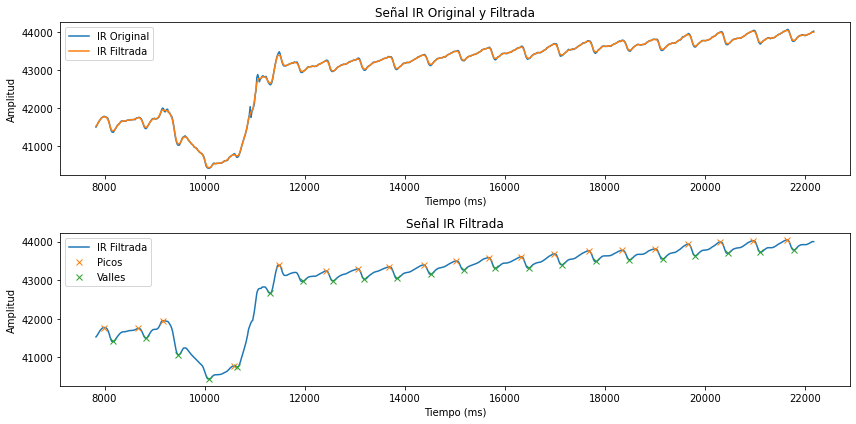

Procesando raw_data_92_76.csv...
Frecuencia Cardíaca Estimada: 82.48 BPM


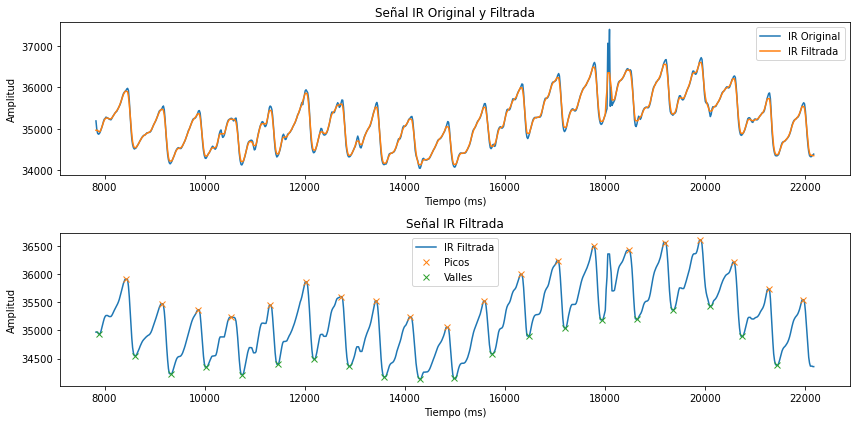

Procesando raw_data_93_100.csv...
Frecuencia Cardíaca Estimada: 90.28 BPM


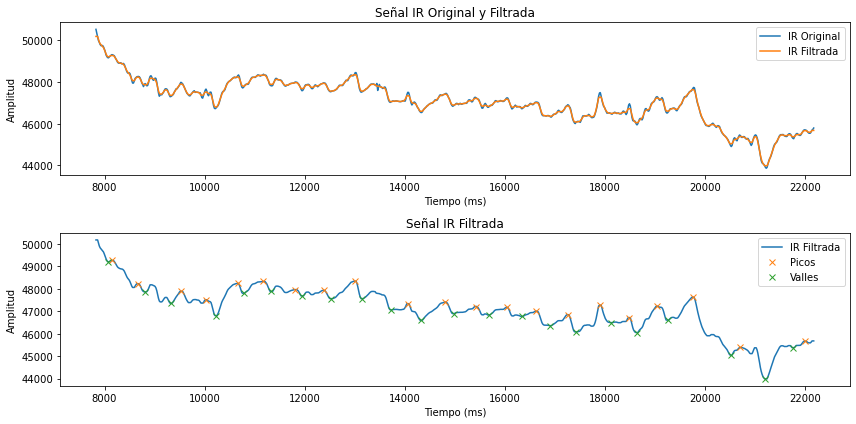

Procesando raw_data_95_77_2.csv...
Frecuencia Cardíaca Estimada: 82.99 BPM


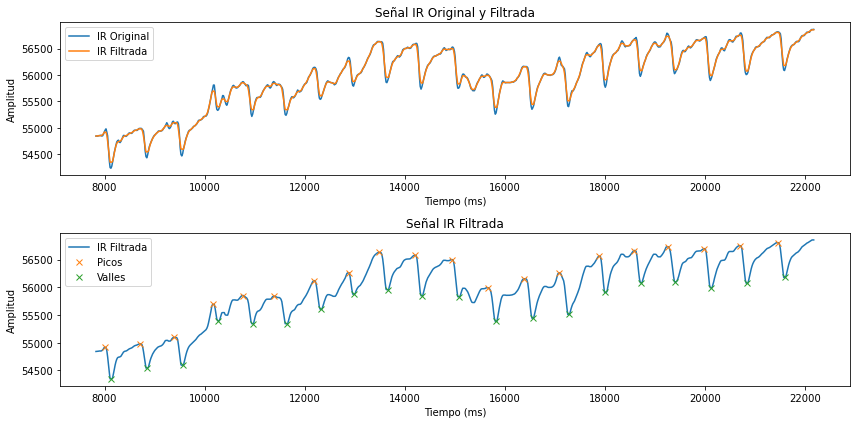

Procesando raw_data_95_80.csv...
Frecuencia Cardíaca Estimada: 75.54 BPM


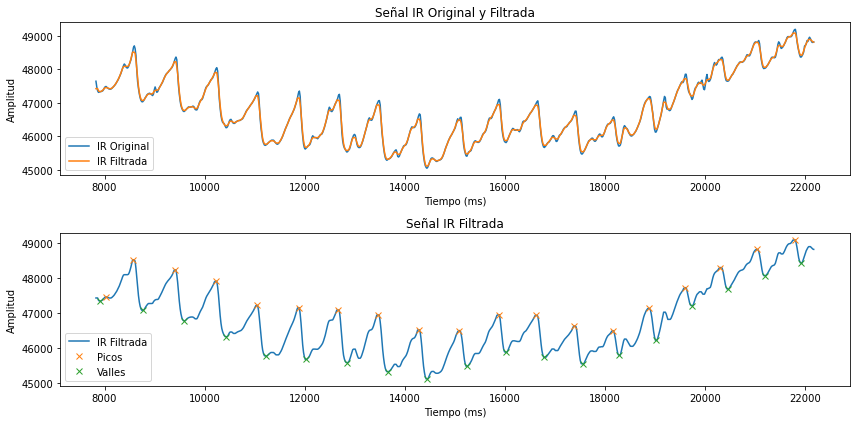

Procesando raw_data_95_81_papa.csv...
Frecuencia Cardíaca Estimada: 78.43 BPM


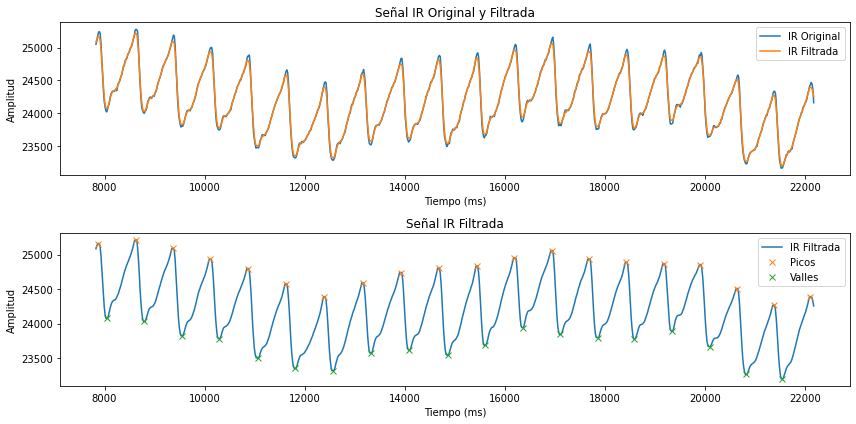

Procesando raw_data_95_99.csv...
Frecuencia Cardíaca Estimada: 92.76 BPM


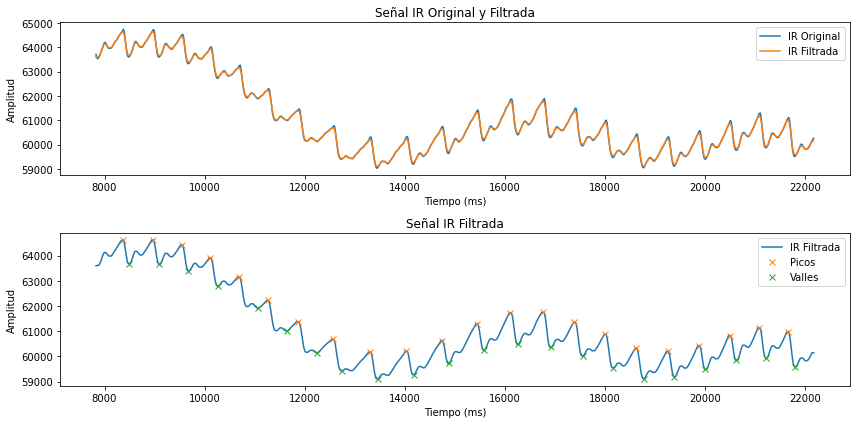

Procesando raw_data_96_69.csv...
Frecuencia Cardíaca Estimada: 69.72 BPM


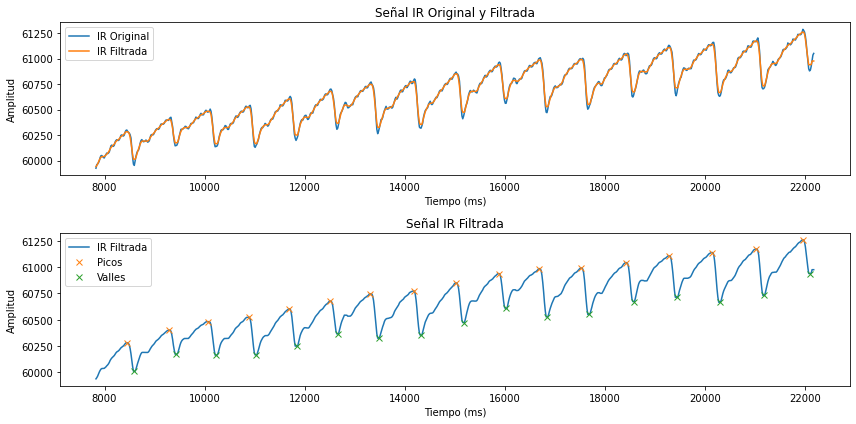

Procesando raw_data_96_81.csv...
Frecuencia Cardíaca Estimada: 77.47 BPM


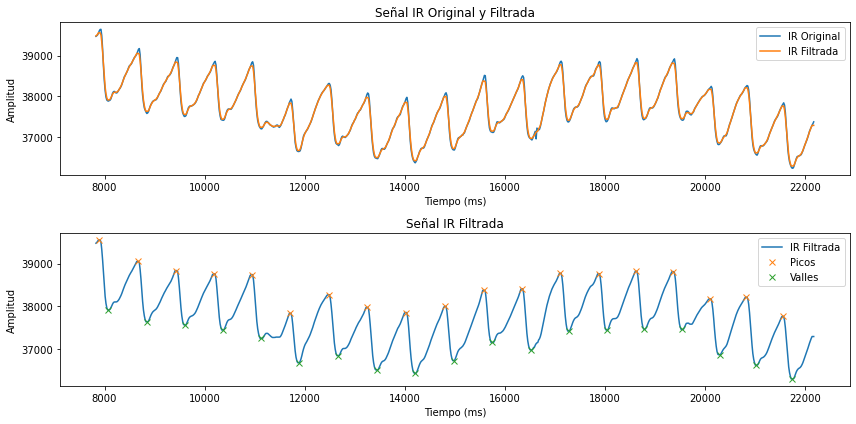

Procesando raw_data_97_95.csv...
Frecuencia Cardíaca Estimada: 93.64 BPM


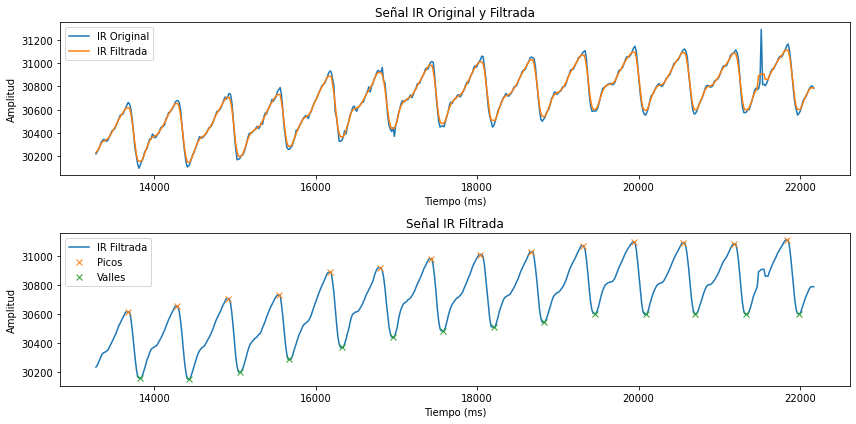

Procesando raw_data_98_81.csv...
Frecuencia Cardíaca Estimada: 78.82 BPM


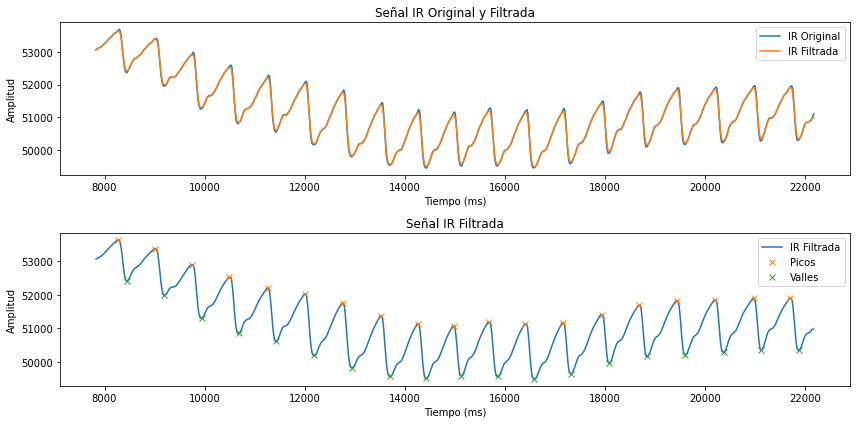

Procesando raw_data_98_86.csv...
Frecuencia Cardíaca Estimada: 85.32 BPM


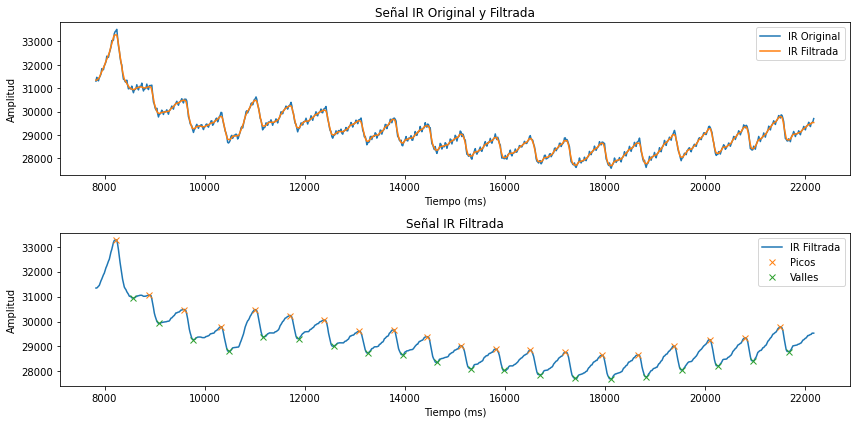

Procesando raw_data_99_73.csv...
Frecuencia Cardíaca Estimada: nan BPM


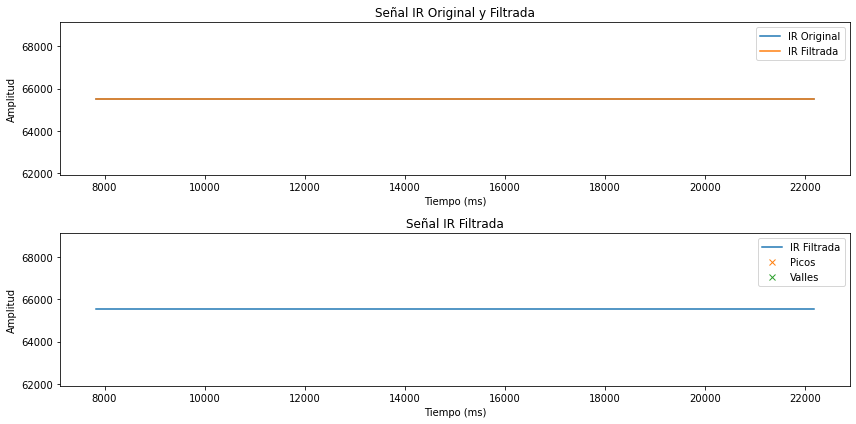

Procesando raw_data_99_75.csv...
Frecuencia Cardíaca Estimada: 73.08 BPM


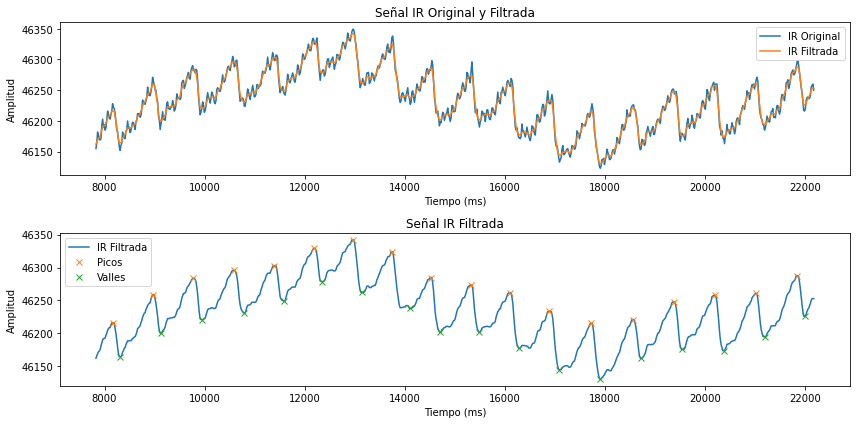

Procesando raw_data_99_91.csv...
Frecuencia Cardíaca Estimada: 76.84 BPM


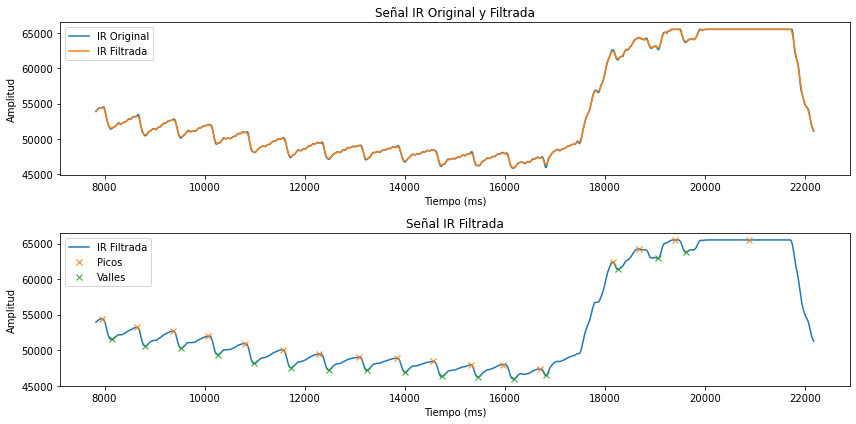

In [5]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from matplotlib import pyplot as plt

# Cargar datos
def load_data(filename):
    df = pd.read_csv(filename)
    if list(df.columns) != ['Tiempo (ms)', 'IR', 'AMB_IR', 'RED', 'AMB_RED']:
        df.columns = ['Tiempo_ms', 'IR', 'AMB_IR', 'RED', 'AMB_RED']
    else:
        df.rename(columns={'Tiempo (ms)': 'Tiempo_ms'}, inplace=True)
    return df


# Eliminar primeros y últimos segundos
def trim_data(df, seconds_to_trim=2):
    fs = estimate_sampling_rate(df)  # Estimar frecuencia de muestreo
    samples_to_trim = int(seconds_to_trim * fs)
    return df.iloc[samples_to_trim:-samples_to_trim].reset_index(drop=True)

# Estimar frecuencia de muestreo
def estimate_sampling_rate(df):
    time_diffs = np.diff(df["Tiempo_ms"]) / 1000  # Convertir ms a s
    return 1 / np.median(time_diffs)

# Aplicar filtro de media móvil con padding
def moving_average_filter(signal, window_size=6):
    pad_size = window_size // 2
    padded_signal = np.pad(signal, (pad_size, pad_size), mode='edge')  # Relleno con los bordes
    filtered_signal = np.convolve(padded_signal, np.ones(window_size)/window_size, mode='valid')

    return filtered_signal

# Calcular frecuencia cardíaca (HR)
def calculate_heart_rate(ir_signal, sampling_rate):
    peaks, _ = signal.find_peaks(ir_signal, distance=sampling_rate*0.5)  # Mínimo 0.5s entre latidos
    peak_intervals = np.diff(peaks) / sampling_rate  # Intervalos entre picos en segundos

    inverted_signal = -1 * ir_signal
    valleys, _ = signal.find_peaks(inverted_signal, distance=sampling_rate*0.5)
    valley_intervals = np.diff(valleys) / sampling_rate

    if len(valley_intervals) > 0 or len(peak_intervals) > 0:
        heart_rate = 60 / np.mean(valley_intervals)
        #heart_rate = 60 / np.mean(peak_intervals)
    else:
        heart_rate = np.nan
    return heart_rate, peaks, valleys


def calculate_and_graph(filename):
    data = load_data(filename)
    data = trim_data(data, seconds_to_trim=8)
    data["IR_filtered"] = moving_average_filter(data["IR"], window_size=5)
    data["IR_filtered"] = signal.medfilt(data["IR_filtered"], kernel_size=5)  # Filtro de mediana

    # Estimar HR
    fs = estimate_sampling_rate(data)
    #print(f"Frecuencia de muestreo estimada: {fs:.2f} Hz")

    # Calcular frecuencia cardíaca
    heart_rate, peaks, valleys = calculate_heart_rate(data["IR_filtered"], fs)

    #Calculo de la frecuencia cardiaca con FFT


    # Resultados
    print(f"Frecuencia Cardíaca Estimada: {heart_rate:.2f} BPM")

    # Graficar las señal R original y la filtrada con los picos
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(data["Tiempo_ms"], data["IR"], label='IR Original')
    plt.plot(data["Tiempo_ms"], data["IR_filtered"], label='IR Filtrada')
    plt.title('Señal IR Original y Filtrada')
    plt.xlabel('Tiempo (ms)')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(data["Tiempo_ms"], data["IR_filtered"], label='IR Filtrada')
    plt.plot(data["Tiempo_ms"].iloc[peaks], data["IR_filtered"].iloc[peaks], "x", label='Picos')
    plt.plot(data["Tiempo_ms"].iloc[valleys], data["IR_filtered"].iloc[valleys], "x", label='Valles')
    plt.title('Señal IR Filtrada')  
    plt.xlabel('Tiempo (ms)')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ejecutar la funcion para todos los archivos en un directorio dadp
import os
directory = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2"
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        print(f"Procesando {filename}...")
        calculate_and_graph(file_path)
    else:
        continue


# Diagrama de bloques

Datos RAW (IR) \
   ↓\
Recorte de inicio/fin\
   ↓\
Filtro media móvil\
   ↓\
Filtro mediana\
   ↓\
Detección de picos/valles\
   ↓\
Cálculo Frecuencia Cardíaca (HR)\
   ↓\
Visualización / Resultado


# Resumen de los resultados

In [4]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from matplotlib import pyplot as plt
import os
import re

# Funciones auxiliares
def load_data(filename):
    df = pd.read_csv(filename, decimal=',')
    df.columns = ['Tiempo_ms', 'IR', 'AMB_IR', 'RED', 'AMB_RED']
    return df

def trim_data(df, seconds_to_trim=8):
    fs = estimate_sampling_rate(df)
    samples_to_trim = int(seconds_to_trim * fs)
    return df.iloc[samples_to_trim:-samples_to_trim].reset_index(drop=True)

def estimate_sampling_rate(df):
    time_diffs = np.diff(df["Tiempo_ms"]) / 1000
    return 1 / np.median(time_diffs)

def moving_average_filter(signal, window_size=6):
    pad_size = window_size // 2
    padded_signal = np.pad(signal, (pad_size, pad_size), mode='edge')
    return np.convolve(padded_signal, np.ones(window_size)/window_size, mode='valid')

def calculate_heart_rate(ir_signal, sampling_rate):
    peaks, _ = signal.find_peaks(ir_signal, distance=sampling_rate*0.5)
    valley_signal = -1 * ir_signal
    valleys, _ = signal.find_peaks(valley_signal, distance=sampling_rate*0.5)
    valley_intervals = np.diff(valleys) / sampling_rate
    if len(valley_intervals) > 0:
        return 60 / np.mean(valley_intervals)
    return np.nan

# Ruta
directory = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2"
resultados = []

# Procesamiento por archivo
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        try:
            df = load_data(file_path)
            df = trim_data(df, seconds_to_trim=8)
            df["IR_filtered"] = moving_average_filter(df["IR"], window_size=5)
            df["IR_filtered"] = signal.medfilt(df["IR_filtered"], kernel_size=5)
            fs = estimate_sampling_rate(df)
            hr = calculate_heart_rate(df["IR_filtered"], fs)
        except Exception as e:
            print(f" Error procesando {filename}: {e}")
            hr = np.nan

        match = re.match(r".*_(\d+)_(\d+)", filename)
        expected_hr = int(match.group(2)) if match else None

        resultados.append({
            "Archivo": filename,
            "FC esperada (bpm)": expected_hr,
            "FC estimada (bpm)": round(hr, 2) if not np.isnan(hr) else "Error"
        })

# Crear tabla
tabla = pd.DataFrame(resultados)
print(tabla)

# Guardar CSV
csv_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados\resultados_media_mediana.csv"
tabla.to_csv(csv_path, index=False)

# Guardar imagen PNG
fig, ax = plt.subplots(figsize=(11, len(tabla) * 0.5 + 1))
ax.axis('off')
tabla_img = ax.table(cellText=tabla.values,
                     colLabels=tabla.columns,
                     cellLoc='center',
                     loc='center')
tabla_img.auto_set_font_size(False)
tabla_img.set_fontsize(10)
tabla_img.scale(1, 1.5)

png_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados\resultados_media_mediana.png"
plt.savefig(png_path, bbox_inches='tight', dpi=300)
plt.close()


                    Archivo  FC esperada (bpm) FC estimada (bpm)
0        raw_data_91_91.csv                 91             90.72
1        raw_data_92_76.csv                 76             82.48
2       raw_data_93_100.csv                100             90.28
3      raw_data_95_77_2.csv                  2             82.99
4        raw_data_95_80.csv                 80             75.54
5   raw_data_95_81_papa.csv                 81             78.43
6        raw_data_95_99.csv                 99             92.76
7        raw_data_96_69.csv                 69             69.72
8        raw_data_96_81.csv                 81             77.47
9        raw_data_97_95.csv                 95             93.64
10       raw_data_98_81.csv                 81             78.82
11       raw_data_98_86.csv                 86             85.32
12       raw_data_99_73.csv                 73             Error
13       raw_data_99_75.csv                 75             73.08
14       raw_data_99_91.c